<a href="https://colab.research.google.com/github/arvchak/MLProj/blob/main/protonetwork_efficientnet_10_way_5_shot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow
#!pip install tensornets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import glob
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import pathlib
from PIL import Image
from numpy.linalg import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/new_train.zip

Streaming output truncated to the last 5000 lines.
  inflating: new_train/val/roundabout/roundabout_196.jpg  
  inflating: new_train/val/roundabout/roundabout_141.jpg  
  inflating: new_train/val/roundabout/roundabout_627.jpg  
  inflating: new_train/val/roundabout/roundabout_633.jpg  
  inflating: new_train/val/roundabout/roundabout_155.jpg  
  inflating: new_train/val/roundabout/roundabout_169.jpg  
  inflating: new_train/val/roundabout/roundabout_151.jpg  
  inflating: new_train/val/roundabout/roundabout_637.jpg  
  inflating: new_train/val/roundabout/roundabout_623.jpg  
  inflating: new_train/val/roundabout/roundabout_145.jpg  
  inflating: new_train/val/roundabout/roundabout_179.jpg  
  inflating: new_train/val/roundabout/roundabout_192.jpg  
  inflating: new_train/val/roundabout/roundabout_186.jpg  
  inflating: new_train/val/roundabout/roundabout_435.jpg  
  inflating: new_train/val/roundabout/roundabout_353.jpg  
  inflating: new_train/val/roundabout/roundabout_347.jpg  
  inf

In [ ]:
root_path = '/content/new_train'
output = '/content/new_train'

In [ ]:
data_dir = pathlib.Path(root_path)
count =  len(list(data_dir.glob('*/*.jpg')))
print(count)

0


In [ ]:
#!pip install split-folders
##import splitfolders
#splitfolders.ratio(root_path , output , seed = 42 , ratio = (.7, .2 ,.1), group_prefix = None)

In [ ]:
data_dir_train = pathlib.Path(output+'/train')
data_dir_test = pathlib.Path(output+'/test')
data_dir_val = pathlib.Path(output+'/val')

In [ ]:
batch_size = 45
img_height = 128
img_width = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 23100 files belonging to 33 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val, 
    image_size = (img_height, img_width), 
    batch_size = (batch_size))

Found 8400 files belonging to 12 classes.


In [ ]:
class_names = train_ds.class_names
val_class_names = val_ds.class_names
print(class_names)
no_of_classes = len(class_names)
no_val_classes = len(val_class_names)
#train_np = np.stack(list(train_ds))

['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'storage_tank', 'tennis_court', 'terrace']


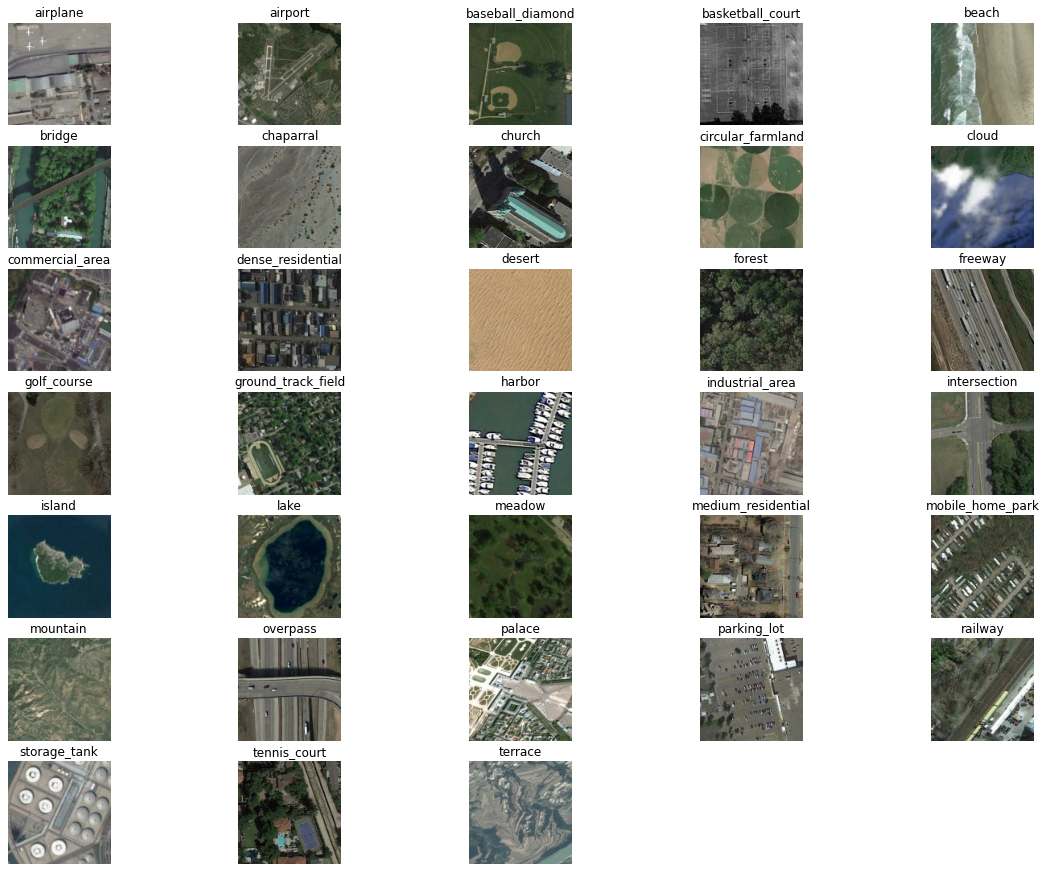

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
j = 0
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(9, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

In [ ]:
#train_dataset = np.zeros([no_of_classes, 3, img_height, img_width], dtype=object)
examples = np.zeros([no_of_classes, 700, img_height, img_width,3], dtype=np.float32)
for train in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], train))
  for image, label in filtered_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_train , class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      examples[label.numpy()[0], index] = values


In [ ]:
test_data = np.zeros([no_val_classes, 700, img_height, img_width,3], dtype=np.float32)
for val in range(len(val_class_names)):
  filtered_val_ds = val_ds.filter(lambda x, l: tf.math.equal(l[0], val))
  for image, label in filtered_val_ds.take(1):
    img_files = sorted(glob.glob(os.path.join(data_dir_val , val_class_names[label.numpy()[0]], '*.jpg')))
    for index, img_file in enumerate(img_files):
      values =  np.array(Image.open(img_file).resize((img_width, img_height)), np.float32, copy=False)
      test_data[label.numpy()[0], index] = values


In [ ]:
sample_img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


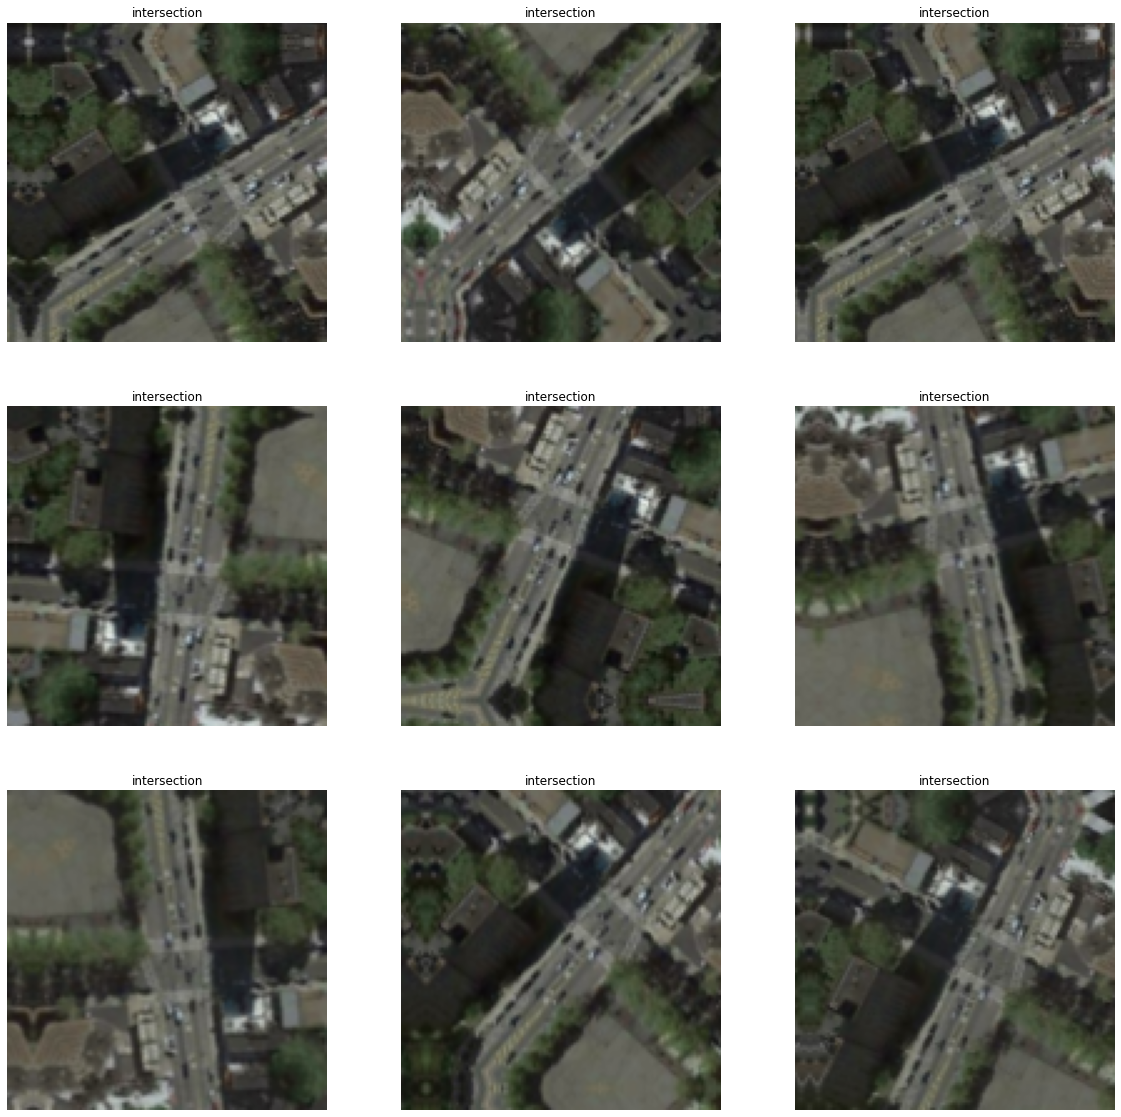

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = sample_img_augmentation(image)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[label.numpy()[0]])
        plt.axis("off")

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


In [ ]:
def base_model(inputs, h_dim , z_dim):
    layer_inputs = layers.Input(tensor = inputs)
    #x = img_augmentation(inputs)
    x = img_augmentation(layer_inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False
       # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)

    net = cnn(inputs, h_dim)
    net = cnn(net, h_dim)
    net = cnn(net, h_dim) 
    net = cnn(net, z_dim) 
    net = tf.keras.layers.Flatten()(net)
    

    # Rebuild top
    return tf.concat([x, net], axis = 1)

In [ ]:
def cnn(inputs, op_channels):
    conv = tf.compat.v1.layers.conv2d(inputs, op_channels, kernel_size=3, padding='SAME')
    conv = tf.compat.v1.layers.batch_normalization(conv,scale=True, center=True)
    conv = tf.nn.swish(conv)
    conv = tf.compat.v1.layers.max_pooling2d(conv, strides = 2, pool_size=2, padding = 'SAME')
    return conv

In [ ]:
#number of classes
num_way = 10

#number of examples per class for support set
num_shot = 5

#number of query points
num_query = 5

#number of examples
num_examples = 70

channel = 3

h_dim = 64

z_dim = 64

In [ ]:
support_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
query_set = tf.compat.v1.placeholder(tf.float32, [None, None, img_height, img_width, 3])
label = tf.compat.v1.placeholder(tf.int64, [None, None])

In [ ]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)


In [ ]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [ ]:
num_query_points = query_set_shape[1]

In [ ]:
y = tf.compat.v1.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)
print(y_one_hot.shape)


label_prime = tf.one_hot(label , depth = num_classes)

(None, None, None)


In [ ]:
#output = build_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]))
support_set_embeddings = base_model(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channel]), h_dim, z_dim)

Instructions for updating:
Colocations handled automatically by placer.
16719872/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [ ]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]
class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

In [ ]:
#query_output = build_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]))
query_set_embeddings = base_model(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channel]), h_dim, z_dim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:463: UserWarning: `layer.appl

In [ ]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)
   
    

In [ ]:
print(support_set_embeddings.shape)
print(query_set_embeddings.shape)
print(class_prototype.shape)

distance = euclidean_distance(query_set_embeddings,class_prototype)
print(distance)

predicted_probability = tf.reshape(tf.nn.log_softmax(-distance) , [num_classes, num_query_points, -1])
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predicted_probability, axis=-1), y), tf.float32))

train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


(None, 5376)
(None, 5376)
(None, 5376)
Tensor("Mean_1:0", shape=(None, None), dtype=float32)


In [ ]:
sess = tf.compat.v1.InteractiveSession()
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()
sess.run(init)

In [ ]:
num_epochs = 50
num_episodes = 100
train_accuracy_over_epochs = []
train_loss_over_epochs = []
test_accuracy_over_epochs = []
test_loss_over_epochs = []

In [ ]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = examples[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = examples[class_, selected[num_shot:]]
            
        #=support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        train_accuracy_over_epochs.append(accuracy_)
        train_loss_over_epochs.append(loss_)
        if (episode+1) % 100 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 100 : Loss: 1.5457571744918823, Accuracy: 0.41999998688697815
Epoch 2 : Episode 100 : Loss: 1.823815941810608, Accuracy: 0.2199999988079071
Epoch 3 : Episode 100 : Loss: 1.6911180019378662, Accuracy: 0.47999998927116394
Epoch 4 : Episode 100 : Loss: 1.5583984851837158, Accuracy: 0.4000000059604645
Epoch 5 : Episode 100 : Loss: 1.9195858240127563, Accuracy: 0.47999998927116394
Epoch 6 : Episode 100 : Loss: 1.7585949897766113, Accuracy: 0.3799999952316284
Epoch 7 : Episode 100 : Loss: 1.8148446083068848, Accuracy: 0.46000000834465027
Epoch 8 : Episode 100 : Loss: 1.415377140045166, Accuracy: 0.47999998927116394
Epoch 9 : Episode 100 : Loss: 0.9672608971595764, Accuracy: 0.6800000071525574
Epoch 10 : Episode 100 : Loss: 1.7093276977539062, Accuracy: 0.47999998927116394
Epoch 11 : Episode 100 : Loss: 1.980804443359375, Accuracy: 0.2199999988079071
Epoch 12 : Episode 100 : Loss: 1.3727655410766602, Accuracy: 0.47999998927116394
Epoch 13 : Episode 100 : Loss: 1.173795223236

In [ ]:

n_test_episodes = 3000
n_test_way = 5
n_test_shot = 5
n_test_query = 5
n_test_classes = test_data.shape[0]


In [ ]:
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test_accuracy_over_epochs.append(ac)
        test_loss_over_epochs.append(ls)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 2.222163438796997, Accuracy: 0.4000000059604645
Episode 20 : Loss: 0.6181231141090393, Accuracy: 0.800000011920929
Episode 30 : Loss: 1.3575952053070068, Accuracy: 0.47999998927116394
Episode 40 : Loss: 0.44747552275657654, Accuracy: 0.800000011920929
Episode 50 : Loss: 1.2786741256713867, Accuracy: 0.47999998927116394
Episode 60 : Loss: 1.536840796470642, Accuracy: 0.4399999976158142
Episode 70 : Loss: 0.7222522497177124, Accuracy: 0.6800000071525574
Episode 80 : Loss: 0.824250340461731, Accuracy: 0.7200000286102295
Episode 90 : Loss: 0.7066209316253662, Accuracy: 0.7599999904632568
Episode 100 : Loss: 1.7136011123657227, Accuracy: 0.47999998927116394
Episode 110 : Loss: 1.000545859336853, Accuracy: 0.6399999856948853
Episode 120 : Loss: 1.1900979280471802, Accuracy: 0.6000000238418579
Episode 130 : Loss: 0.6330302953720093, Accuracy: 0.7599999904632568
Episode 140 : Loss: 0.7706660628318787, Accuracy: 0.7599999904632568
Episode 150 : Loss: 1.0061222314834595, Accur

In [37]:

n_test_episodes = 3000
n_test_way = 5
n_test_shot = 3
n_test_query = 5
n_test_classes = test_data.shape[0]
test1_accuracy_over_epochs = []
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test1_accuracy_over_epochs.append(ac)
        #test_loss_over_epochs.append(ls)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 1.4703067541122437, Accuracy: 0.47999998927116394
Episode 20 : Loss: 1.1982864141464233, Accuracy: 0.5600000023841858
Episode 30 : Loss: 1.2534193992614746, Accuracy: 0.5600000023841858
Episode 40 : Loss: 1.6140844821929932, Accuracy: 0.6800000071525574
Episode 50 : Loss: 1.4122081995010376, Accuracy: 0.6399999856948853
Episode 60 : Loss: 1.5582355260849, Accuracy: 0.23999999463558197
Episode 70 : Loss: 0.9931029677391052, Accuracy: 0.6000000238418579
Episode 80 : Loss: 1.5468876361846924, Accuracy: 0.47999998927116394
Episode 90 : Loss: 1.1645476818084717, Accuracy: 0.5600000023841858
Episode 100 : Loss: 0.8792033195495605, Accuracy: 0.7599999904632568
Episode 110 : Loss: 1.422049880027771, Accuracy: 0.4399999976158142
Episode 120 : Loss: 1.3460183143615723, Accuracy: 0.5199999809265137
Episode 130 : Loss: 1.2274529933929443, Accuracy: 0.6000000238418579
Episode 140 : Loss: 1.020105004310608, Accuracy: 0.6399999856948853
Episode 150 : Loss: 1.407619595527649, Accura

In [38]:
n_test_episodes = 3000
n_test_way = 5
n_test_shot = 1
n_test_query = 5
n_test_classes = test_data.shape[0]
test2_accuracy_over_epochs = []
for test_episode in range(n_test_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(n_test_classes)[:n_test_way]
        
        support = np.zeros([n_test_way, n_test_shot, img_height, img_width, channel], dtype=np.float32)
        
        query = np.zeros([n_test_way, n_test_query, img_height, img_width, channel], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:n_test_shot + n_test_query]
            support[index] = test_data[class_, selected[:n_test_shot]]
            
            # 5 querypoints per classs
            query[index] = test_data[class_, selected[n_test_shot:]]
            
        #support = np.expand_dims(support, axis=-1)
        #query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
        ls, ac = sess.run([loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        test2_accuracy_over_epochs.append(ac)
        if (test_episode+1) % 10 == 0:
            print('Episode {} : Loss: {}, Accuracy: {}'.format(test_episode+1, ls, ac))

Episode 10 : Loss: 4.842858791351318, Accuracy: 0.2800000011920929
Episode 20 : Loss: 4.38812255859375, Accuracy: 0.23999999463558197
Episode 30 : Loss: 2.4990668296813965, Accuracy: 0.23999999463558197
Episode 40 : Loss: 1.8427752256393433, Accuracy: 0.36000001430511475
Episode 50 : Loss: 1.9590318202972412, Accuracy: 0.5199999809265137
Episode 60 : Loss: 3.7121288776397705, Accuracy: 0.4000000059604645
Episode 70 : Loss: 4.795661926269531, Accuracy: 0.23999999463558197
Episode 80 : Loss: 2.3615963459014893, Accuracy: 0.3199999928474426
Episode 90 : Loss: 1.4065338373184204, Accuracy: 0.6000000238418579
Episode 100 : Loss: 3.9339547157287598, Accuracy: 0.36000001430511475
Episode 110 : Loss: 2.9744369983673096, Accuracy: 0.5600000023841858
Episode 120 : Loss: 4.242530345916748, Accuracy: 0.5600000023841858
Episode 130 : Loss: 2.497354030609131, Accuracy: 0.47999998927116394
Episode 140 : Loss: 2.595637798309326, Accuracy: 0.5199999809265137
Episode 150 : Loss: 2.217338800430298, Accur

In [39]:
sess.close()

In [54]:
np.mean(train_accuracy_over_epochs[::100])

0.54520005

In [41]:
import math 
Z = 1.960
N = 3000
mean = np.mean(test_accuracy_over_epochs)
SE = np.std(test_accuracy_over_epochs) / len(test_accuracy_over_epochs)
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.60884+/-0.003782070031051591


In [42]:
Z = 1.960
N = 3000
mean = np.mean(test1_accuracy_over_epochs)
SE = np.std(test1_accuracy_over_epochs) / len(test1_accuracy_over_epochs)
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.5561866+/-0.00388207434418103


In [43]:
Z = 1.960
N = 3000
mean = np.mean(test2_accuracy_over_epochs)
SE = np.std(test2_accuracy_over_epochs) / len(test2_accuracy_over_epochs)
confidence = Z * (SE * math.sqrt(N))
print(str(mean)+"+/-"+str(confidence))

0.39854667+/-0.0038177069389508924


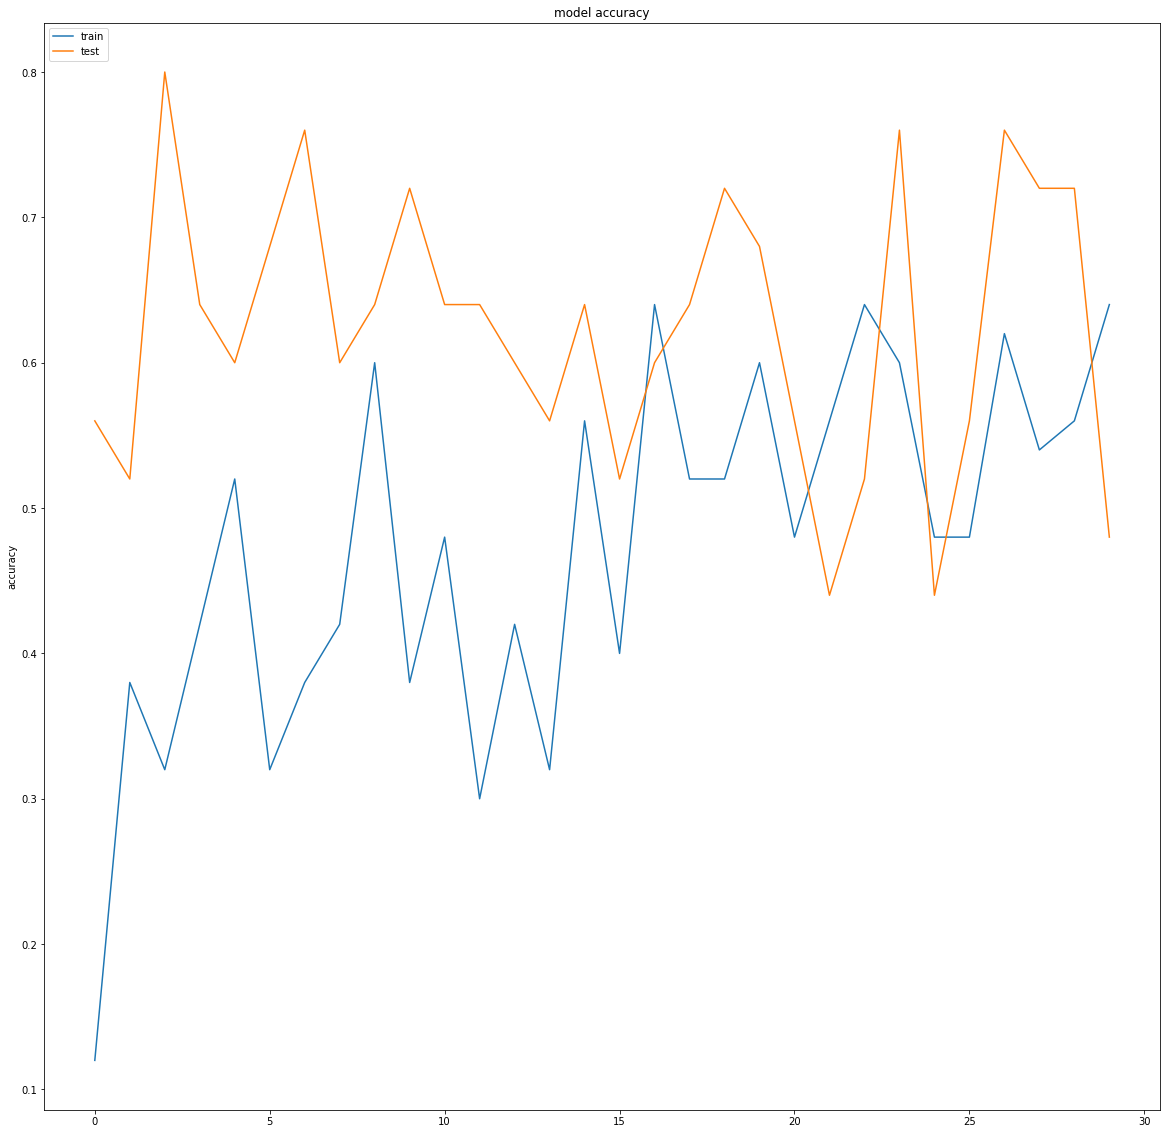

In [51]:
plt.figure(figsize=(20, 20))

plt.plot(train_accuracy_over_epochs[0:3000:100])
plt.plot(test_accuracy_over_epochs[0::100])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6136778372051863825
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1378533094338410556
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [46]:
!cat /proc/meminfo

MemTotal:       53478908 kB
MemFree:        35486012 kB
MemAvailable:   44325764 kB
Buffers:          158472 kB
Cached:          7800376 kB
SwapCached:            0 kB
Active:          8997384 kB
Inactive:        8285216 kB
Active(anon):    8055620 kB
Inactive(anon):    41484 kB
Active(file):     941764 kB
Inactive(file):  8243732 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               724 kB
Writeback:             0 kB
AnonPages:       9323956 kB
Mapped:          1745860 kB
Shmem:             42176 kB
KReclaimable:     283496 kB
Slab:             409724 kB
SReclaimable:     283496 kB
SUnreclaim:       126228 kB
KernelStack:        8512 kB
PageTables:        31508 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    26739452 kB
Committed_AS:   13757648 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       51504 kB
VmallocChunk:          0 kB
Percpu:          